### 데이터셋 정보
Reference: [BrainOmics2024/blob/main/1_Day1/1_FiltNormBatch.ipynb](https://github.com/BrainOmicsCourse/BrainOmics2024/blob/main/1_Day1/1_FiltNormBatch.ipynb)     
* 임시 중기 태아의 피질 데이터셋에 대한 QC 및 필터링
* Single cell transcriptomics 데이터셋 ([논문](https://www.cell.com/cell/fulltext/S0092-8674(21)00942-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867421009429%3Fshowall%3Dtrue))
* [데이터셋 뷰어](https://scbrainregulation.su.domains/)
* 데이터 정보
    * 임신 중기 태아의 뇌피질 샘플
        * 임신 16주~24주의 샘플 4개
    * 시퀀싱 방법: single cell RNA-Sequencing (10x Genomics의 Chromium 유래)
    * 세포 수: ~58,000

### 코드 정보
* [Day0_setting](../../Day0_Setting/)에서 adata를 먼저 생성해주세요
* 이 노트북 코드에서 수행하는 작업
    * 세포에 대한 QC 필터링
    * 유전자에 대한 발현량에 따른 필터링
    * Normalization
    * Log10 transformation
    * Feature selection - HVG 확인
    * Dimensionality reduction - PCA, UMAP
    * Batch correction - Harmony
    * Cluster identification


## 환경 설정

In [1]:
# System
import os
import sys

# Data Analysis
import numpy as np
import pandas as pd

# scRNAseq related
import scanpy as sc
import scanpy.external as sce
from scipy.sparse import csr_matrix, isspmatrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions
sys.path.append('../HelperFunctions')
import Helper as fn

In [2]:
# Threshold for Cell filtering
MIN_GENES = 850
MAX_GENES = 10000
MIN_COUNTS = 1500
MAX_COUNTS = 15000
PCT_MITO = 10 #mitochondrial gene ratio
PCT_RIBO = 25 #ribosomal gene ratio

**미토콘드리아 비율을 확인하는 이유**
> "A high fraction of mitochondrial counts can be indicative of cells with broken membranes. In such cases, the cytoplasmic mRNA has leaked out, leaving behind the more conserved mRNA located in the mitochondria."    
>
> _높은 비율의 미토콘드리아 유전자 발현량은 세포막이 손상된 세포를 나타내는 지표가 될 수 있습니다. 이러한 경우, 세포질의 mRNA는 밖으로 유출되고 미토콘드리아 내의 보존되어있는 mRNA만 남게 됩니다._
>
>_Current best practices in single‐cell RNA‐seq analysis: a tutorial (2019)_

    

**리보솜 유전자 비율을 확인하는 이유**
>"A large number of studies have shown that ribosomal protein-coding genes (RPGs) are highly expressed and co-expressed in many cell types. [...]    
>the expression of RPGs is often correlated with the cell cycle, and in some studies, RPGs are removed before downstream analysis. [...]    
>However, the expression of RPGs can also reflect the metabolic activity of cells, and their expression levels are different in different cell types."
>
>_많은 연구에서 리보솜 단백질 암호화 유전자(RPG)가 다양한 세포 유형에서 높게 발현되고 함께 발현된다는 것을 보여주었습니다. [...]    
>RPG의 발현은 종종 **세포 주기**와 연관되어 있으며, 일부 연구에서는 다음 분석 단계 전에 **RPG를 제거**하기도 합니다. [...]    
>하지만, RPG의 발현은 세포의 대사 활동을 반영할 수도 있으며, 그 발현 수준은 다른 세포 유형에서 다르게 나타납니다._
>
>_Effective ribosomal RNA depletion for single-cell total RNA-seq by scDASH (2021)_

In [3]:
# Threshold for Gene Filtering
PCT_CELLS = 0.25

# HVG 선정과 Batch correction 과정에서 필요한 batch key
BATCH_KEY = 'batch_key'

# Number of Principal component for UMAP
N_PCs = 18 #PCA 분석 -> 차원축소 이후 상위 18개의 주성분만 UMAP 계산에 사용

# 세포 clustering을 위해 사용하는 Leiden 알고리즘을 해상도 0.4로 실행
chosen_leiden = 'Leiden_04' 

## 2. Data Load
### Background


<img src="https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg" width="400">    

scRNA-seq 데이터를 다루기 위해 만들어진 데이터 구조    
* adata.X: 핵심 데이터셋. 행은 세포, 열은 유전자. 희소행렬/밀집행렬을 이용한 메모리효율적 구조로 이루어짐.
* adata.obs: 세포에 대한 메타데이터. 각 행은 adata.X의 행과 같음. Sequencing에 따른 세포유형, 실험배치, QC matrics 등을 가짐
* adata.var: 유전자에 대한 메타데이터. 각 행은 adata.X의 열과 같음. 유전자 ID 등을 가짐
* adata.obsm: 세포에 대한 다차원 데이터.
* adata.varm: 유전자에 대한 다차원 데이터.
* adata.obsp: 세포-세포 사이의 관계를 나타내는 그래프 데이터.
* adata.varp: 유전자-유전사 사이의 관계를 나타내는 그래프 데이터.
* adata.layers: adata.X에 담지 못한 추가 데이터
* adata.uns: 비정형 데이터셋

## 2.1 adata 읽기
### A. Count Matrix

In [4]:
id = 'Id0003'
input_file = f'../data/{id}/1_AssembledAdata.h5ad'
adata = sc.read(input_file)
adata

AnnData object with n_obs × n_vars = 57868 × 33355
    obs: 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'Auth_seurat_clusters', 'Auth_RNA.Counts', 'Auth_RNA.Features', 'Auth_Percent.MT', 'Auth_Percent.Ribo', 'Auth_Cell.Barcode', 'Auth_DF_pANN', 'Auth_DF_classification', 'Auth_DF_pANN_quantile', 'Auth_Spliced.Counts', 'Auth_Spliced.Features', 'Auth_Unspliced.Counts', 'Auth_Unspliced.Features', 'Auth_Ambiguous.Counts', 'Auth_Ambiguous.Features', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'cell_label'
    var: 'start_position', 'end_position', 'chromosome_name', 'ensg'

### B. Barcode metadata
* Barcode = 각 세포들에게 부여된 ID

In [5]:
adata.obs #barcodes

Auth_Sample.ID Auth_Age Auth_Tissue.ID  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCAAGGTAGTAT  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCACAACTCCAA  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCACATAGTCAC  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCAGTACAGGTG  hft_w20_p3_r1    pcw20           HFT3   
...                                       ...      ...            ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGCAGGCTACC  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTCGTACAT  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG  hft_w16_p7_r2    pcw16           HFT7   

                               Auth_Sample.Type Auth_Assay Auth_Batch  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCAAGGTAGTAT              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCACAACTCCAA              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCACATAGTCAC              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCAGTACAGGTG              HFT     RNA v3   b2019_06   
...                                         ...        ...        ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGCAGGCTACC              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGTACAT              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG              HFT     RNA NG   b2020_03   

                               Auth_seurat_clusters  Auth_RNA.Counts  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA                  c16             1397   
hft_w20_p3_r1_AAACCCAAGGTAGTAT                  c11            14338   
hft_w20_p3_r1_AAACCCACAACTCCAA                  c17             9260   
hft_w20_p3_r1_AAACCCACATAGTCAC                   c0             4025   
hft_w20_p3_r1_AAACCCAGTACAGGTG                   c4             7131   
...                                             ...              ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA                   c6             8532   
hft_w16_p7_r2_TTTGTTGCAGGCTACC                   c2             6689   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA                   c2             3865   
hft_w16_p7_r2_TTTGTTGGTCGTACAT                   c2             5293   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG                   c6             5291   

                                Auth_RNA.Features  Auth_Percent.MT  ...  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA                677         0.070866  ...   
hft_w20_p3_r1_AAACCCAAGGTAGTAT               4301         0.053200  ...   
hft_w20_p3_r1_AAACCCACAACTCCAA               3481         0.043511  ...   
hft_w20_p3_r1_AAACCCACATAGTCAC               1969         0.015396  ...   
hft_w20_p3_r1_AAACCCAGTACAGGTG               2930         0.044690  ...   
...                                           ...              ...  ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA               3497         0.018749  ...   
hft_w16_p7_r2_TTTGTTGCAGGCTACC               2393         0.045577  ...   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA               1799         0.035954  ...   
hft_w16_p7_r2_TTTGTTGGTCGTACAT               2365         0.032861  ...   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG               2530         0.006803  ...   

                                Auth_Unspliced.Features Auth_Ambiguous.Counts  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA                       54                    94   
hft_w20_p3_r1_AAACCCAAGGTAGTAT                     2526                  1431   
hft_w20_p3_r1_AAACCCACAACTCCAA                     2515                  1095   
hft_w20_p3_r1_AAACCCACATAGTCAC                     2058                   634   
hft_w20_p3_r1_AAACCCAGTACAGGTG                     2106                   909   
...                      

In [6]:
#바코드 수 확인
adata.n_obs

57868

In [7]:
# 바코드 메타데이터의 feature 확인
adata.obs.columns

Index(['Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type',
       'Auth_Assay', 'Auth_Batch', 'Auth_seurat_clusters', 'Auth_RNA.Counts',
       'Auth_RNA.Features', 'Auth_Percent.MT', 'Auth_Percent.Ribo',
       'Auth_Cell.Barcode', 'Auth_DF_pANN', 'Auth_DF_classification',
       'Auth_DF_pANN_quantile', 'Auth_Spliced.Counts', 'Auth_Spliced.Features',
       'Auth_Unspliced.Counts', 'Auth_Unspliced.Features',
       'Auth_Ambiguous.Counts', 'Auth_Ambiguous.Features', 'dataset_id',
       'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'cell_label'],
      dtype='object')

<Axes: xlabel='sample_id'>

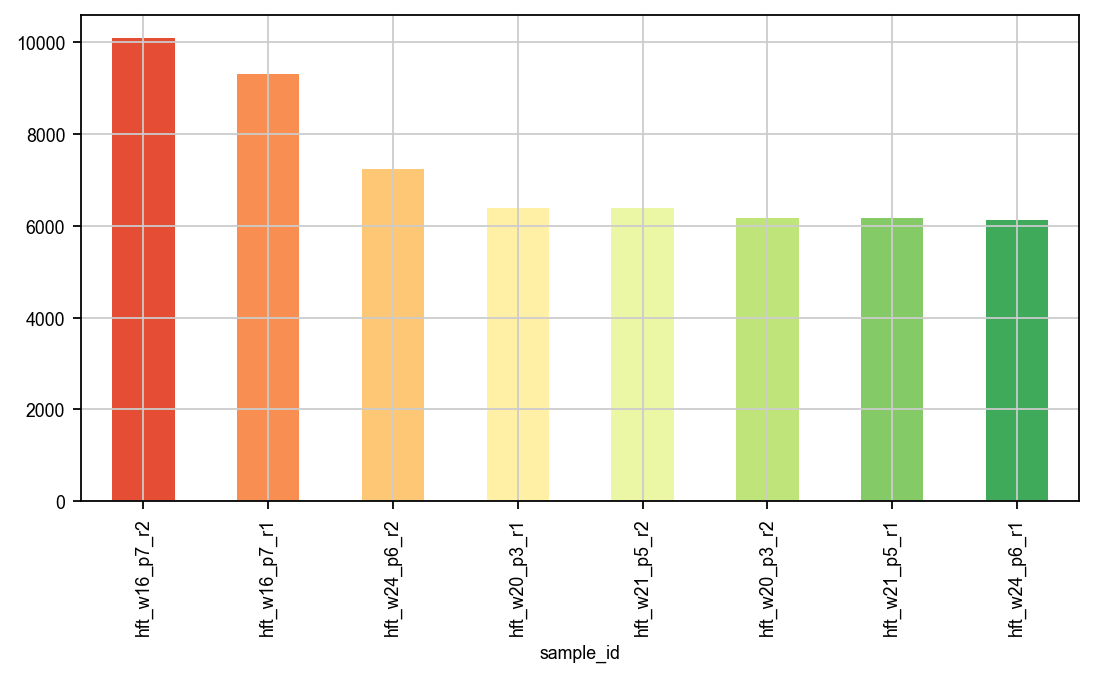

In [8]:
#바코드 'sample_id' 시각화
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['sample_id'].value_counts())))

adata.obs['sample_id'].value_counts().plot.bar(color=category_colors)

In [9]:
# 바코드 메타데이터의 cell_label feature 확인
adata.obs['cell_label'].unique()

['Microglia', 'GliaPg', 'OPC_Oligo', 'ExN_N5', 'ExN_N4', ..., 'ExN_N1', 'ExN_N6', 'ExN_N8', 'RBC', 'VLMC']
Length: 23
Categories (23, object): ['CycProg', 'Endo', 'ExN_N1', 'ExN_N2', ..., 'RG_late', 'SubPlate', 'VLMC', 'tRG']

<Axes: xlabel='cell_label'>

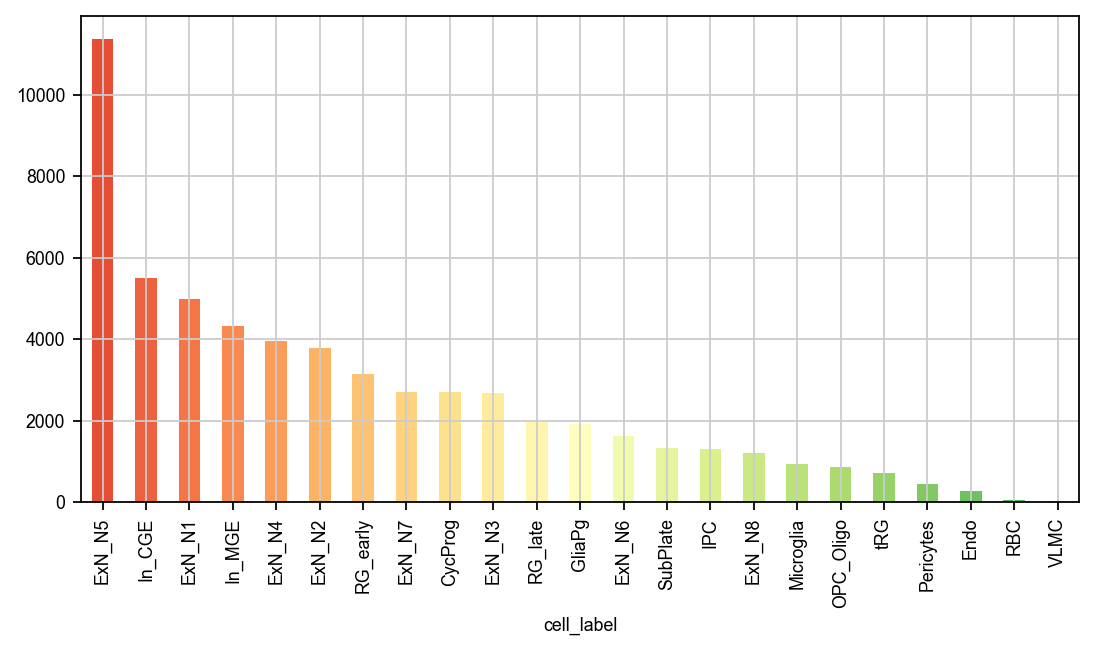

In [10]:
# 바코드 메타데이터의 cell_label 시각화
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['cell_label'].value_counts())))

adata.obs['cell_label'].value_counts().plot.bar(color=category_colors)

In [11]:
# 바코드의 메타데이터에서 cell_label 차원을 축소한 cell_class라는 새로운 feature를 만들어보자
Dict = {'ExN_N5': 'ExN', 'In_CGE': 'InN', 'ExN_N1': 'ExN',
        'In_MGE': 'InN', 'ExN_N4': 'ExN', 'ExN_N2': 'ExN', 
        'RG_early': 'Pg', 'ExN_N7': 'ExN', 'CycProg': 'Pg', 
        'ExN_N3': 'ExN', 'RG_late': 'Pg', 'GliaPg': 'Pg', 
        'ExN_N6': 'ExN', 'SubPlate': 'ExN', 'IPC': 'IPC', 
        'ExN_N8': 'ExN', 'Microglia': 'Microglia', 'OPC_Oligo': 'OPC_Oligo', 
        'tRG': 'Pg', 'Pericytes': 'Other', 'Endo': 'Other',
        'RBC': 'Other', 'VLMC': 'Other'
       }

adata.obs['cell_class'] = adata.obs['cell_label'].replace(Dict)

/var/folders/c5/7n1ywn_x79v664c15cr0h_0m0000gp/T/ipykernel_65685/85219887.py:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['cell_class'] = adata.obs['cell_label'].replace(Dict)


<Axes: xlabel='cell_class'>

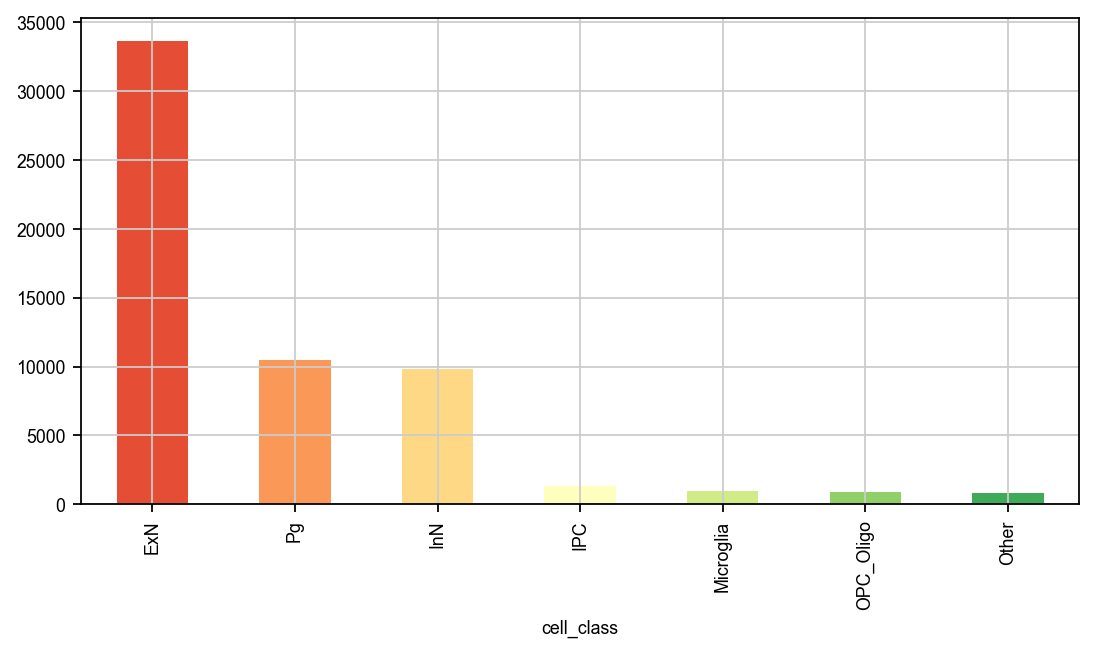

In [12]:
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['cell_class'].value_counts())))

adata.obs['cell_class'].value_counts().plot.bar(color=category_colors)

### C. Gene metadata

In [13]:
adata.var #genes

start_position  end_position chromosome_name  \
external_gene_name                                                 
MIR1302-2HG                28589.0       31109.0               1   
FAM138A                    34553.0       37595.0               1   
OR4F5                      65419.0       71585.0               1   
ENSG00000238009                NaN           NaN             NaN   
ENSG00000239945            89551.0       91105.0               1   
...                            ...           ...             ...   
MT-ND4L                    10470.0       10766.0              MT   
MT-ND4                     10760.0       12137.0              MT   
MT-ND5                     12337.0       14148.0              MT   
MT-ND6                     14149.0       14673.0              MT   
MT-CYB                     14747.0       15887.0              MT   

                               ensg  
external_gene_name                   
MIR1302-2HG         ENSG00000243485  
FAM138A             ENSG00000237613  
OR4F5               ENSG00000186092  
ENSG00000238009     ENSG00000238009  
ENSG00000239945     ENSG00000239945  
...                             ...  
MT-ND4L             ENSG00000212907  
MT-ND4              ENSG00000198886  
MT-ND5              ENSG00000198786  
MT-ND6              ENSG00000198695  
MT-CYB              ENSG00000198727  

[33355 rows x 4 columns]

In [14]:
#유전자 수 확인
adata.n_vars

33355

In [15]:
#유전자 메타데이터의 feature 확인
adata.var.columns

Index(['start_position', 'end_position', 'chromosome_name', 'ensg'], dtype='object')

### 2.2 Top-expressed genes

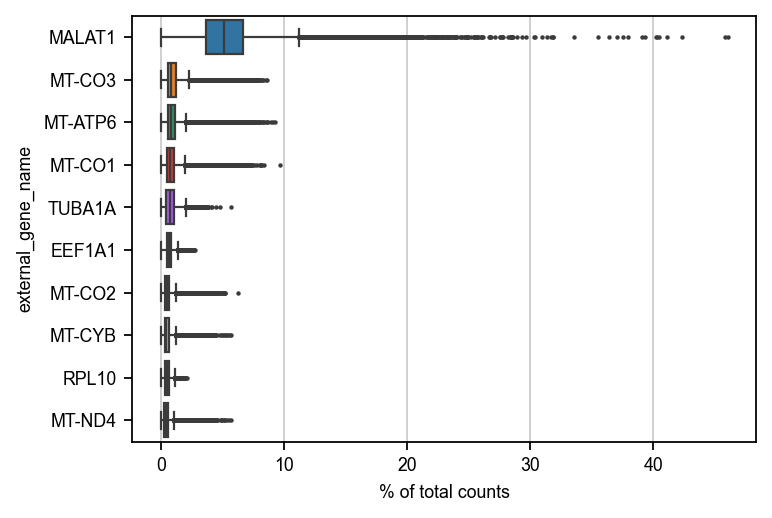

In [16]:
#Scanpy를 이용하여 '발현량이 높은 유전자들을' 확인
sc.pl.highest_expr_genes(adata, n_top=10)

## 2.3 Calculate QCs
QC의 일환으로 미토콘드리아, 리보솜 유전자 비율 feature를 바코드(obs) 메타데이터 feature에 추가

In [17]:
#Find mito and ribo genes
mito_genes = adata.var_names.str.startswith('MT-')   
ribo_genes = adata.var_names.str.contains('^RPS|^RPL')

#qc_vars wants a column of adata.var containing T/F or 1/0 indicating the genes to be selected for sub-statistics
adata.var['mito'] = adata.var_names.str.startswith('MT-')    
adata.var['ribo']= adata.var_names.str.contains('^RPS|^RPL')

#Compute metrics (inplace=True to append to adata)
sc.pp.calculate_qc_metrics(adata, log1p=True, qc_vars=['mito','ribo'], inplace=True, percent_top=None)

In [18]:
adata.obs["gene_UMI_ratio"] = adata.obs["n_genes_by_counts"] / adata.obs["total_counts"]
adata.obs["log1p_gene_UMI_ratio"] = np.log1p(adata.obs["gene_UMI_ratio"])

In [19]:
adata.obs

Auth_Sample.ID Auth_Age Auth_Tissue.ID  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCAAGGTAGTAT  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCACAACTCCAA  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCACATAGTCAC  hft_w20_p3_r1    pcw20           HFT3   
hft_w20_p3_r1_AAACCCAGTACAGGTG  hft_w20_p3_r1    pcw20           HFT3   
...                                       ...      ...            ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGCAGGCTACC  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTCGTACAT  hft_w16_p7_r2    pcw16           HFT7   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG  hft_w16_p7_r2    pcw16           HFT7   

                               Auth_Sample.Type Auth_Assay Auth_Batch  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCAAGGTAGTAT              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCACAACTCCAA              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCACATAGTCAC              HFT     RNA v3   b2019_06   
hft_w20_p3_r1_AAACCCAGTACAGGTG              HFT     RNA v3   b2019_06   
...                                         ...        ...        ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGCAGGCTACC              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGTACAT              HFT     RNA NG   b2020_03   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG              HFT     RNA NG   b2020_03   

                               Auth_seurat_clusters  Auth_RNA.Counts  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA                  c16             1397   
hft_w20_p3_r1_AAACCCAAGGTAGTAT                  c11            14338   
hft_w20_p3_r1_AAACCCACAACTCCAA                  c17             9260   
hft_w20_p3_r1_AAACCCACATAGTCAC                   c0             4025   
hft_w20_p3_r1_AAACCCAGTACAGGTG                   c4             7131   
...                                             ...              ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA                   c6             8532   
hft_w16_p7_r2_TTTGTTGCAGGCTACC                   c2             6689   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA                   c2             3865   
hft_w16_p7_r2_TTTGTTGGTCGTACAT                   c2             5293   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG                   c6             5291   

                                Auth_RNA.Features  Auth_Percent.MT  ...  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA                677         0.070866  ...   
hft_w20_p3_r1_AAACCCAAGGTAGTAT               4301         0.053200  ...   
hft_w20_p3_r1_AAACCCACAACTCCAA               3481         0.043511  ...   
hft_w20_p3_r1_AAACCCACATAGTCAC               1969         0.015396  ...   
hft_w20_p3_r1_AAACCCAGTACAGGTG               2930         0.044690  ...   
...                                           ...              ...  ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA               3497         0.018749  ...   
hft_w16_p7_r2_TTTGTTGCAGGCTACC               2393         0.045577  ...   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA               1799         0.035954  ...   
hft_w16_p7_r2_TTTGTTGGTCGTACAT               2365         0.032861  ...   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG               2530         0.006803  ...   

                                total_counts log1p_total_counts  \
hft_w20_p3_r1_AAACCCAAGCTGCGAA          1397           7.242798   
hft_w20_p3_r1_AAACCCAAGGTAGTAT         14338           9.570738   
hft_w20_p3_r1_AAACCCACAACTCCAA          9260           9.133567   
hft_w20_p3_r1_AAACCCACATAGTCAC          4025           8.300529   
hft_w20_p3_r1_AAACCCAGTACAGGTG          7131           8.872347   
...                                      ...                ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA          85

## 3. Discard low quality barcodes and lowly expressed genes
* 다음의 feature들을 확인하고 기준을 만족하지 못하는 바코드 데이터는 삭제한다.
    * 미토콘드리아 유전자 수: 높으면 삭제
    * 리보솜 유전자 수: 높으면 삭제
    * `n_genes_by_counts`: 한 바코드(세포) 내에 존재하는 모든 유전자의 '종류'
    * `Total_counts`: 한 바코드(세포) 내에 존재하는 모든 유전자의 '수'

In [20]:
#바코드 중에서 'sample_id'를 확인하면 데이터의 총 샘플의 수를 알 수 있다.
adata.obs['sample_id'].unique().to_list()

#4명에서 각각 read1, read2가 생성되었다.

/var/folders/c5/7n1ywn_x79v664c15cr0h_0m0000gp/T/ipykernel_65685/582929284.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  adata.obs['sample_id'].unique().to_list()


['hft_w20_p3_r1',
 'hft_w20_p3_r2',
 'hft_w21_p5_r1',
 'hft_w21_p5_r2',
 'hft_w24_p6_r1',
 'hft_w24_p6_r2',
 'hft_w16_p7_r1',
 'hft_w16_p7_r2']

### 10x Genomics의 Single Cell 3' v2 라이브러리 시퀀싱에서 Read 1과 Read 2의 역할
* Read 1: 어떤 세포에서 유래한 RNA인지 식별하는 UMI 바코드 정보
* Read 2: 실제 유전자 서열(cDNA) 정보

## 3.1 Visualize thresholds on distribution

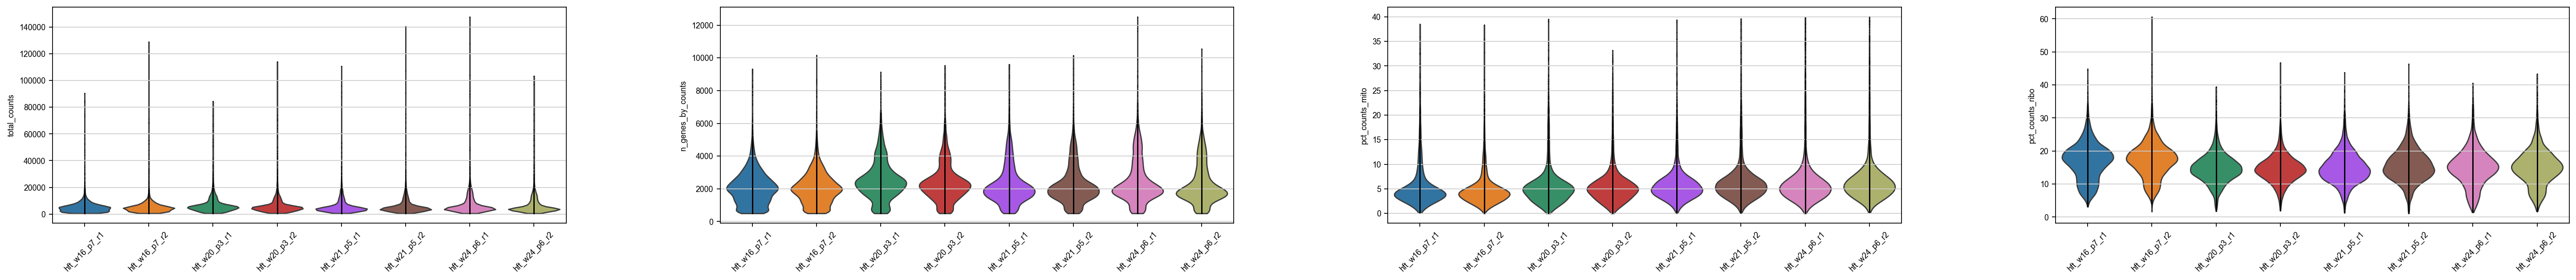

In [21]:
sc.pl.violin(
    adata,
    keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo'],
    groupby='sample_id',
    jitter=False,
    multi_panel=True,
    rotation=45
    )

## 3.3. Filtering barcodes

In [22]:
# QC 기준 재확인
print('\nThe selected filtering parameters are:' 
      '\n Minimum counts: ' , MIN_COUNTS, '\n Maximum counts:' , MAX_COUNTS,
      '\n Minimum genes: ' , MIN_GENES, '\n Maximum genes:' , MAX_GENES,
      '\n Mitocondia: ' , PCT_MITO, '%', '\n Ribosomal: ', PCT_RIBO, '%')


The selected filtering parameters are:
 Minimum counts:  1500 
 Maximum counts: 15000 
 Minimum genes:  850 
 Maximum genes: 10000 
 Mitocondia:  10 % 
 Ribosomal:  25 %


### 3.3.1 Detected Genes

In [23]:
# QC1. 유전자 기준 미달인 바코드 제거
sc.pp.filter_cells(adata, min_genes=MIN_GENES)
sc.pp.filter_cells(adata, max_genes=MAX_GENES)

print('After filtering detected genes: number of cells:', adata.n_obs)

After filtering detected genes: number of cells: 52758


### 3.3.2 UMI Counts

In [24]:
# QC2. 하나의 바코드(세포) 당 발견된 유전자의 수 기준 미달인 바코드 제거
sc.pp.filter_cells(adata, min_counts = MIN_COUNTS)
sc.pp.filter_cells(adata, max_counts = MAX_COUNTS)

print('After filtering on min UMI counts:number of cells:', adata.n_obs)

After filtering on min UMI counts:number of cells: 49758


### 3.3.3 Mitochondrial RNA

In [25]:
# QC3. 미토콘드리아 유전자 수 기준 미달인 바코드 제거
adata = adata[adata.obs['pct_counts_mito'] < PCT_MITO, :]

print('After filtering on mitochondrial RNA: number of cells:', adata.n_obs)

After filtering on mitochondrial RNA: number of cells: 47211


### 3.3.4 Ribosomal RNA

In [26]:
# QC4. 리보솜 유전자 수 기준 미달인 바코드 제거
adata = adata[adata.obs['pct_counts_ribo'] < PCT_RIBO, :]

print('After filtering on ribosomal protein RNA: number of cells:', adata.n_obs)

After filtering on ribosomal protein RNA: number of cells: 45888


## 3.4 Filtering genes

In [27]:
# QC5. 유전자 발현 수 기준 미달인 유전자 제거
MIN_CELLS = np.rint((adata.n_obs*PCT_CELLS)/100)

sc.pp.filter_genes(adata, min_cells=MIN_CELLS)
print('After gene filtering: number of genes:', adata.n_vars)

/opt/miniconda3/envs/Brainomics/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After gene filtering: number of genes: 16324


## 3.5 Numbers after filtering

<Axes: xlabel='sample_id'>

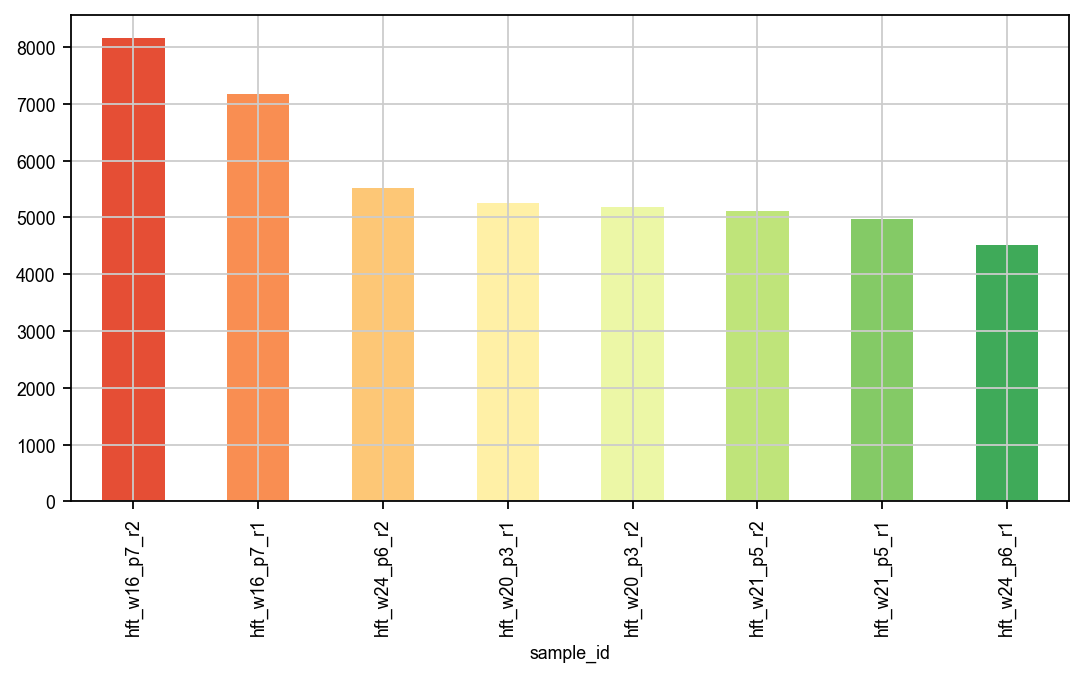

In [28]:
sc.settings.set_figure_params(fontsize=8, figsize=[8, 4])

category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, len(adata.obs['sample_id'].value_counts())))

adata.obs['sample_id'].value_counts().plot.bar(color=category_colors)

## 4. Normalize and Log Transform
정규화(Normalization) 및 로그변환
* 바코드 사이의 데이터 편차를 보완
    * 바코드 마다 다른 total_counts(RNA 분자의 총량)을 정규화
    * 로그변환을 통해 데이터의 편차를 줄여 분포를 안정화

## 4.1 Store raw counts in 'counts' layer

In [29]:
# 데이터를 새로운 레이어에 백업
adata.layers['counts'] = adata.X.copy()

## 4.2 Basic Scanpy Noarmalization

>sc.pp.normalize_total에 대한 Scanpy 공식 문서에 나오는, 기억해두면 유용한 몇 가지 파라미터들입니다.    
> * target_sum: 만약 None으로 설정되면, 정규화 후 각 세포(observation)의 총 카운트는 정규화 이전 모든 세포들의 총 카운트의 중앙값(median)과 같아집니다. 
> * exclude_highly_expressed: 각 세포의 정규화 계수(size factor)를 계산할 때, 매우 높게 발현된 유전자를 제외합니다. 어떤 유전자가 단 하나의 세포에서라도 전체 카운트의 max_fraction보다 많은 카운트를 가질 경우, '매우 높게 발현된' 유전자로 간주됩니다. 제외되지 않은 유전자들의 합이 target_sum이 됩니다.    
> * max_fraction: 기본값은 0.05인 float 타입입니다. exclude_highly_expressed=True일 때, 어떤 유전자가 최소 한 개의 세포에서라도 원래 총 카운트의 max_fraction보다 많은 카운트를 가질 경우, 그 유전자를 매우 높게 발현된 것으로 간주합니다.

In [30]:
# 정규화 수행
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
    exclude_highly_expressed=True
    )

In [31]:
# 로그변환 수행
sc.pp.log1p(adata)

## 4.3 Store normalized counts

In [32]:
# 정규화된 데이터를 layers에 저장
adata.layers['lognormcounts']=adata.X.copy()
print(adata.layers['lognormcounts'][:, adata.var_names == 'ACTB'][:6])

  (np.int32(0), np.int32(0))	3.31702100370616
  (np.int32(1), np.int32(0))	2.74287886342992
  (np.int32(2), np.int32(0))	2.862554522458528
  (np.int32(3), np.int32(0))	3.013129919072555
  (np.int32(4), np.int32(0))	3.0224127335562008
  (np.int32(5), np.int32(0))	3.6503539069618687


## 4.4 Alternative workflow: normalization by Scran
Scran을 이용한 normalization도 가능하다

## 5. Feature Selection: Highly Variable Genes
Highly VariableGenes: 세포들 사이에서 발현량이 크게 변하는 유전자
* 어떤 유전자가 세포 종류에 따라 발현량이 크게 달라진다면, 그 유전자는 세포의 종류를 구별하는 중요한 단서가 될 가능성이 높다
* 평균 발현량에 비해 상대적으로 분산이 큰 유전자를 찾는다

## 5.1 Scanpy workflow

In [33]:
# Scanpy를 이용하여 HVG를 탐색하는 방법은 하단의 주소를 함께 참고
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html
# min_mean, max_mean, min_disp는 기본값을 이용했다
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    batch_key=BATCH_KEY
    )

In [34]:
print('Number of Higly Variable Genes', len(adata.var_names[adata.var['highly_variable'] == True]))

Number of Higly Variable Genes 1545


## 5.2 Alternative workflow: Triku
Triku를 이용한 HVG를 추려내는 방법도 가능하다

## 6. Dimensionality Reduction
* HVG만을 추려내었지만 여전히 데이터의 차원은 1500에 달한다
* 이렇게 고차원의 데이터는 시각화 같은 데이터 분석기법을 적용하기 어렵다
* 따라서 PCA - UMAP 두 단계를 통한 차원축소를 수행하여, 데이터 분석을 용이하게 만든다

## 6.1 PCA (Principal Component Analysis, 주성분 분석)
>데이터의 **분산을 가장 잘 설명하는 새로운 축들(주성분, Principal Components)**을 찾아냅니다.    
> **첫 번째 주성분(PC1)**은 데이터의 분산을 가장 많이 설명하는 축입니다.    
> **두 번째 주성분(PC2)**은 PC1과 직교하면서(상관관계가 없으면서) 남은 분산을 가장 잘 설명하는 축입니다.    
> 이 과정을 반복하여 PC3, PC4 등을 계속 찾아냅니다.    

In [35]:
### PCA 수행
sc.pp.pca(
    adata,
    n_comps=30, #계산할 주성분(Principal Components, PC)의 개수
    mask_var='highly_variable', #PCA를 계산할 때 어떤 유전자(feature)를 사용할지 지정 #HVG
    svd_solver='arpack' #PCA 계산에 사용할 수학적인 알고리즘(solver)을 지정
    )

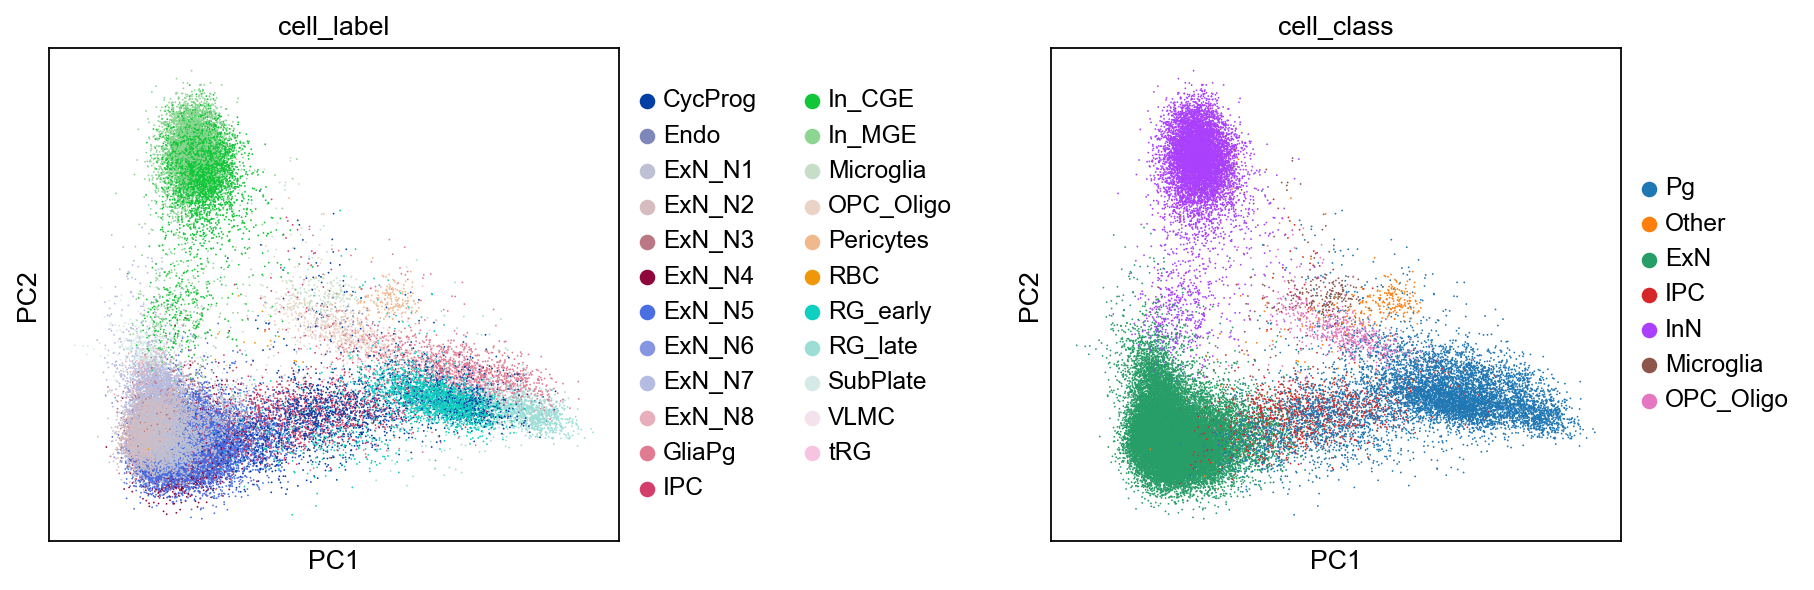

In [37]:
# 바코드에 따른 시각화
sc.settings.set_figure_params(dpi=80, fontsize=12)
sc.pl.pca(adata, color=['cell_label', 'cell_class'], ncols=2, wspace=0.6)

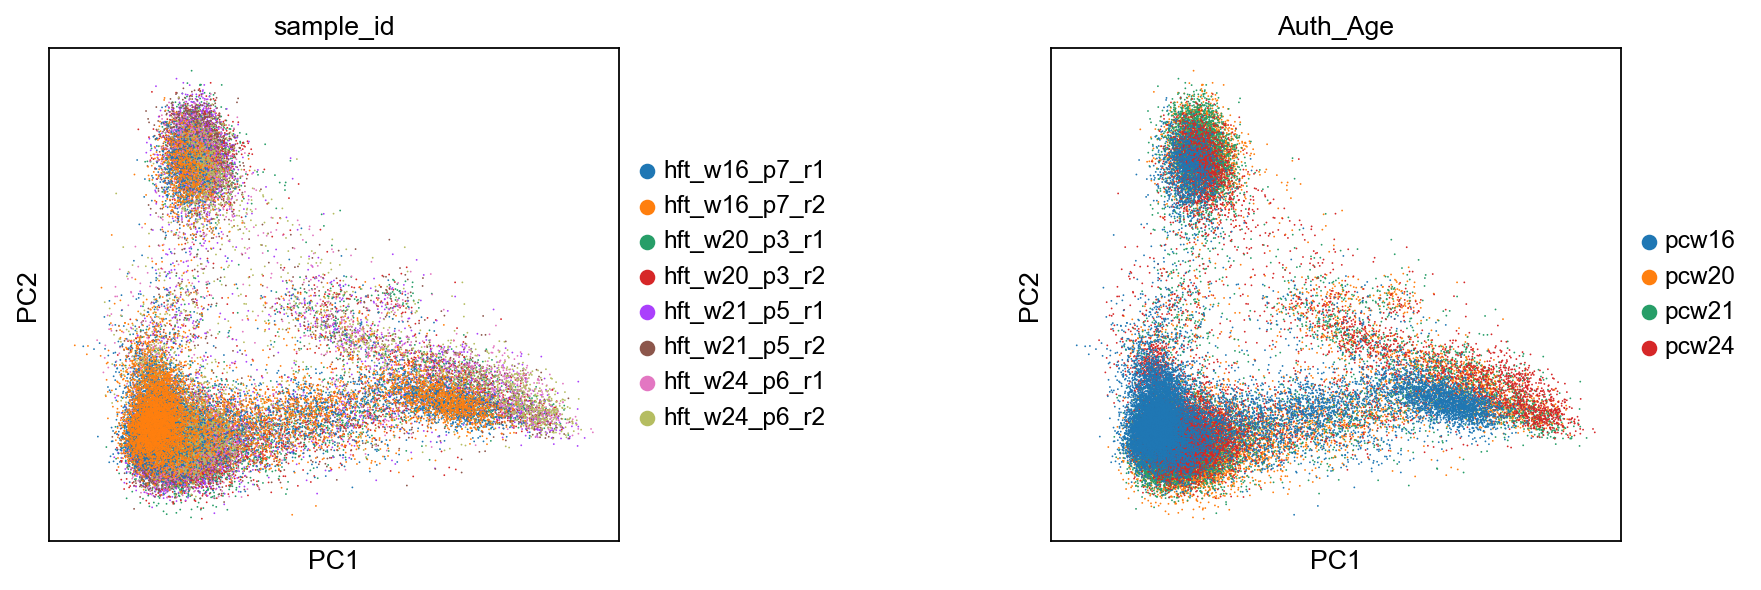

In [36]:
# 샘플에 따른 시각화
sc.settings.set_figure_params(dpi=80, fontsize=12)
sc.pl.pca(adata, color=['sample_id', 'Auth_Age'], ncols=2, wspace=0.6)

## 6.2 Neighbors
* PCA를 거쳐 차원이 축소된 데이터를 UMAP으로 분석하기 전에 할 일이 있다
* 바로 PCA 공간 내에서 서로 인접한 데이터를 파악하고 저장하는 일이다
* UMAP은 neighbors 그래프의 구조를 최대한 유지하면서 세포들을 2차원 평면에 시각화할 것이다

In [38]:
N_NB = int(0.5 * len(adata) ** 0.5)
if N_NB > 80:
    N_NB = 80

sc.pp.neighbors(adata, n_neighbors=N_NB, n_pcs=N_PCs, key_added="pca")

/opt/miniconda3/envs/Brainomics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 6.3 UMAP
>UMAP은 그래프 기반의 비선형 차원 축소 기법입니다.    
>이 기법은 데이터셋의 고차원 그래프 표현을 구축한 뒤, 저차원의 그래프 표현이 원래 그래프와 구조적으로 최대한 유사해지도록 최적화합니다.

In [39]:
sc.tl.umap(adata, random_state=1, neighbors_key="pca")
# store coordinates in a named slot so to avoid confusion with batch-corrected
adata.obsm["X_umap_nocorr"] = adata.obsm["X_umap"].copy()
del adata.obsm["X_umap"]

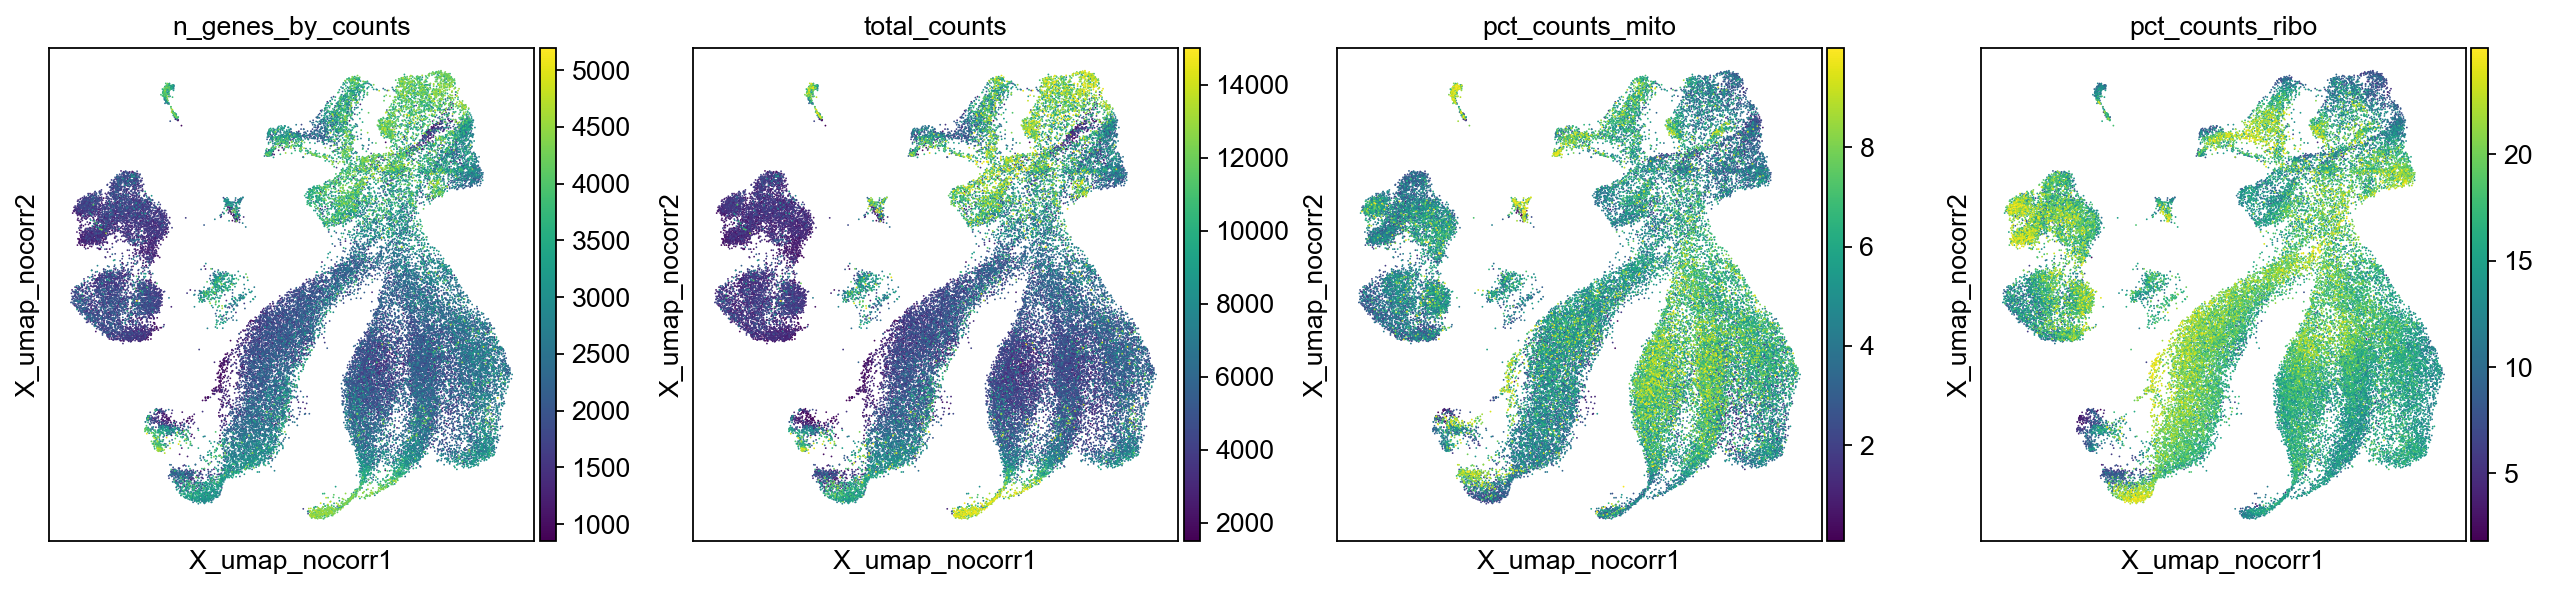

In [40]:
sc.pl.embedding(adata, basis="X_umap_nocorr", 
                color=['n_genes_by_counts',"total_counts", 'pct_counts_mito', 'pct_counts_ribo'])

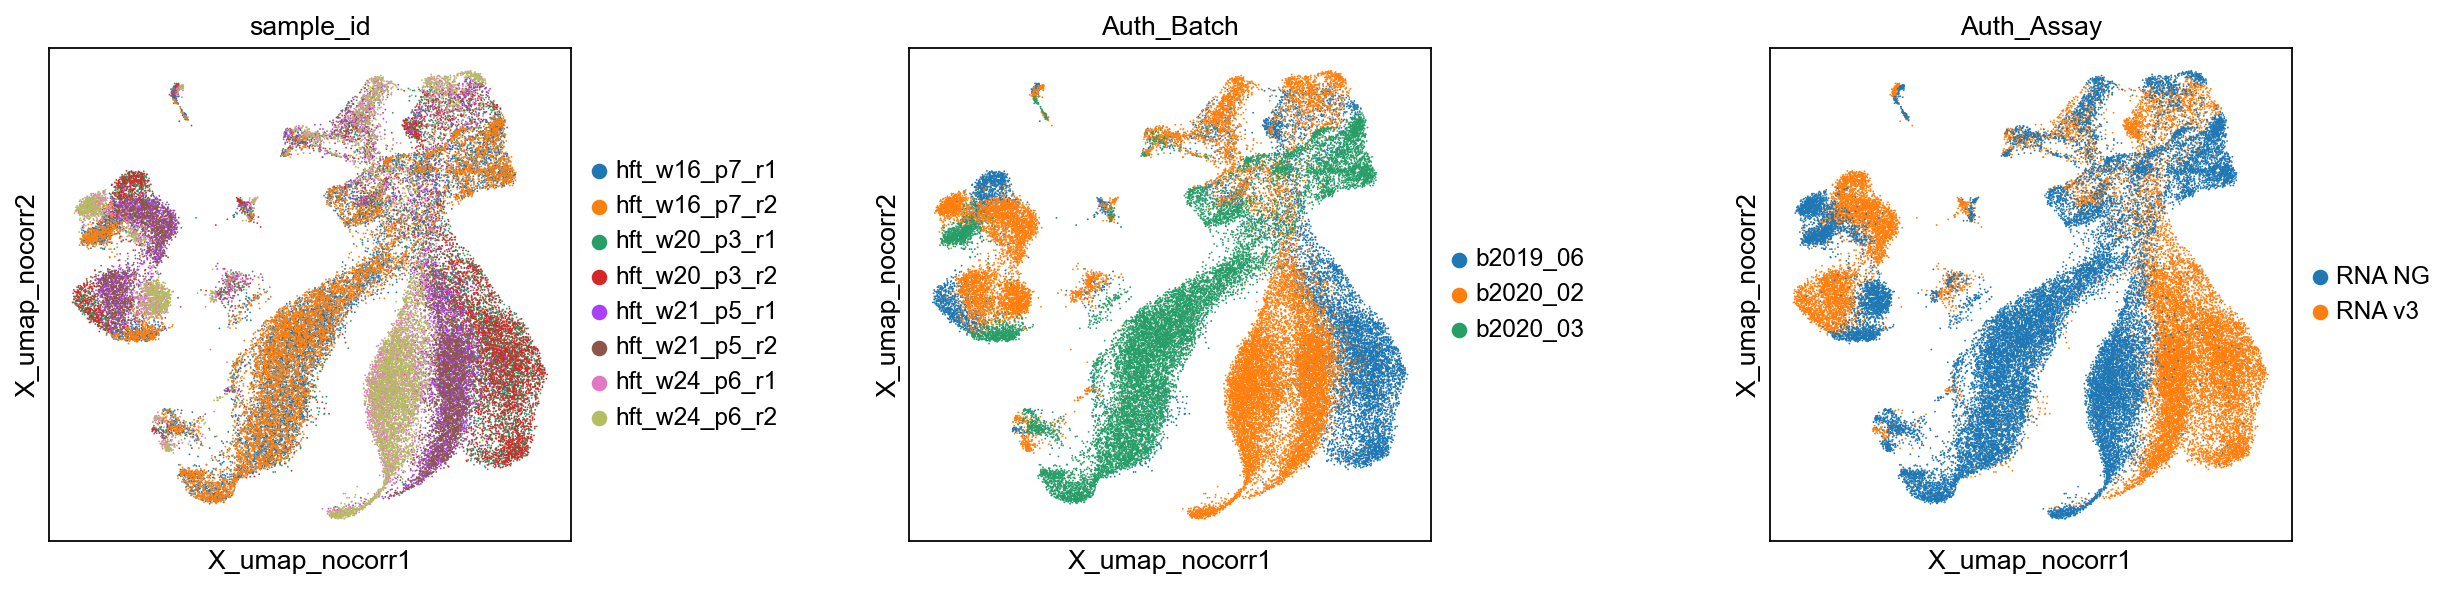

In [41]:
sc.pl.embedding(adata,  basis="X_umap_nocorr", color=['sample_id', 'Auth_Batch', 'Auth_Assay'], wspace=0.5)

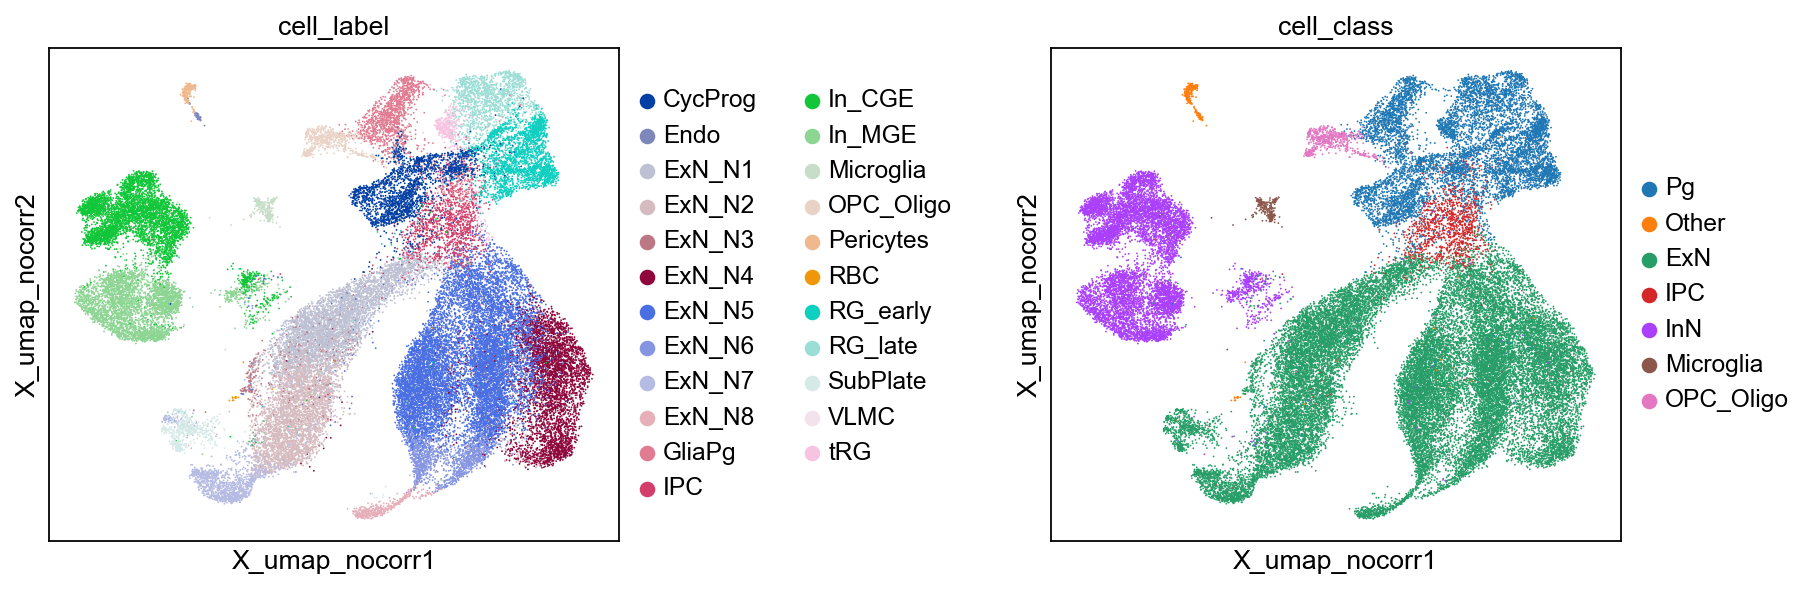

In [42]:
if 'cell_label' in adata.obs.columns:
    sc.pl.embedding(adata, basis="X_umap_nocorr", color=['cell_label', 'cell_class'],  wspace=0.6)

## 7. Batch correction by Harmony
* 배치 효과(Batch Effect): 샘플 처리 날짜, 실험자, 장비 등 요인으로 인해 데이터에 변동이 발생하는 현상
* Harmony는 반복적인 클러스터링 접근법을 사용하여 다른 배치의 세포들을 정렬합니다. 각 반복 단계는 다음과 같습니다
    * 여러 데이터셋의 세포들을 그룹화하기 위한 소프트 k-평균 클러스터링
    * 각 클러스터에 대한 전역 중심점(global centroid)과 데이터셋 특이적 중심점(dataset-specific centroid) 계산
    * 이 중심점들로부터 보정 계수(correction factor) 계산
    * 이 보정 계수를 사용하여 각 세포를 세포 특이적인 계수로 보정

In [43]:
sc.external.pp.harmony_integrate(adata, BATCH_KEY)

2025-08-06 17:24:21,327 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-06 17:24:23,096 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-06 17:24:23,183 - harmonypy - INFO - Iteration 1 of 10
2025-08-06 17:24:27,715 - harmonypy - INFO - Iteration 2 of 10
2025-08-06 17:24:32,201 - harmonypy - INFO - Iteration 3 of 10
2025-08-06 17:24:36,669 - harmonypy - INFO - Iteration 4 of 10
2025-08-06 17:24:41,374 - harmonypy - INFO - Iteration 5 of 10
2025-08-06 17:24:44,136 - harmonypy - INFO - Converged after 5 iterations


In [44]:
sc.pp.neighbors(
    adata,
    n_neighbors=N_NB,
    n_pcs=N_PCs,
    use_rep='X_pca_harmony',
    key_added='harmony'
    )

## 8. Batch-corrected dimensionality reduction

## 8.1 UMAP

In [45]:
sc.tl.umap(adata, random_state=1, neighbors_key="harmony")
adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()
del adata.obsm["X_umap"]

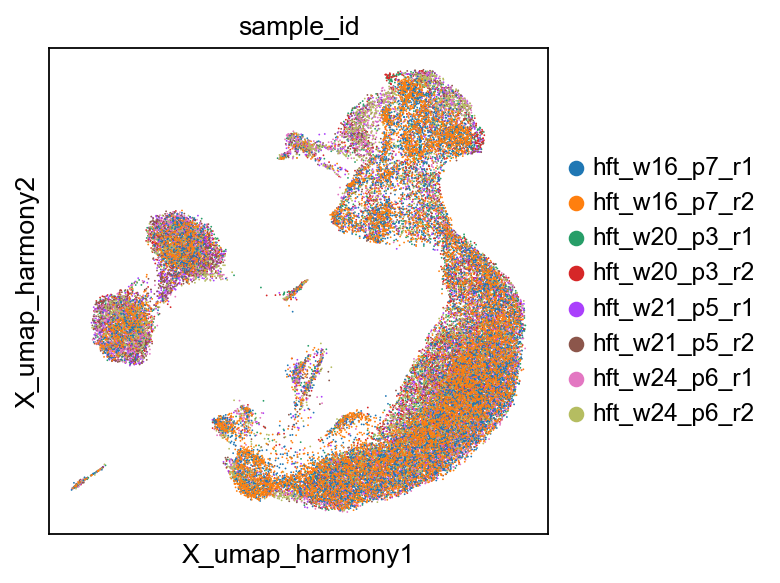

In [46]:
sc.pl.embedding(adata, basis="X_umap_harmony", color=['sample_id'])

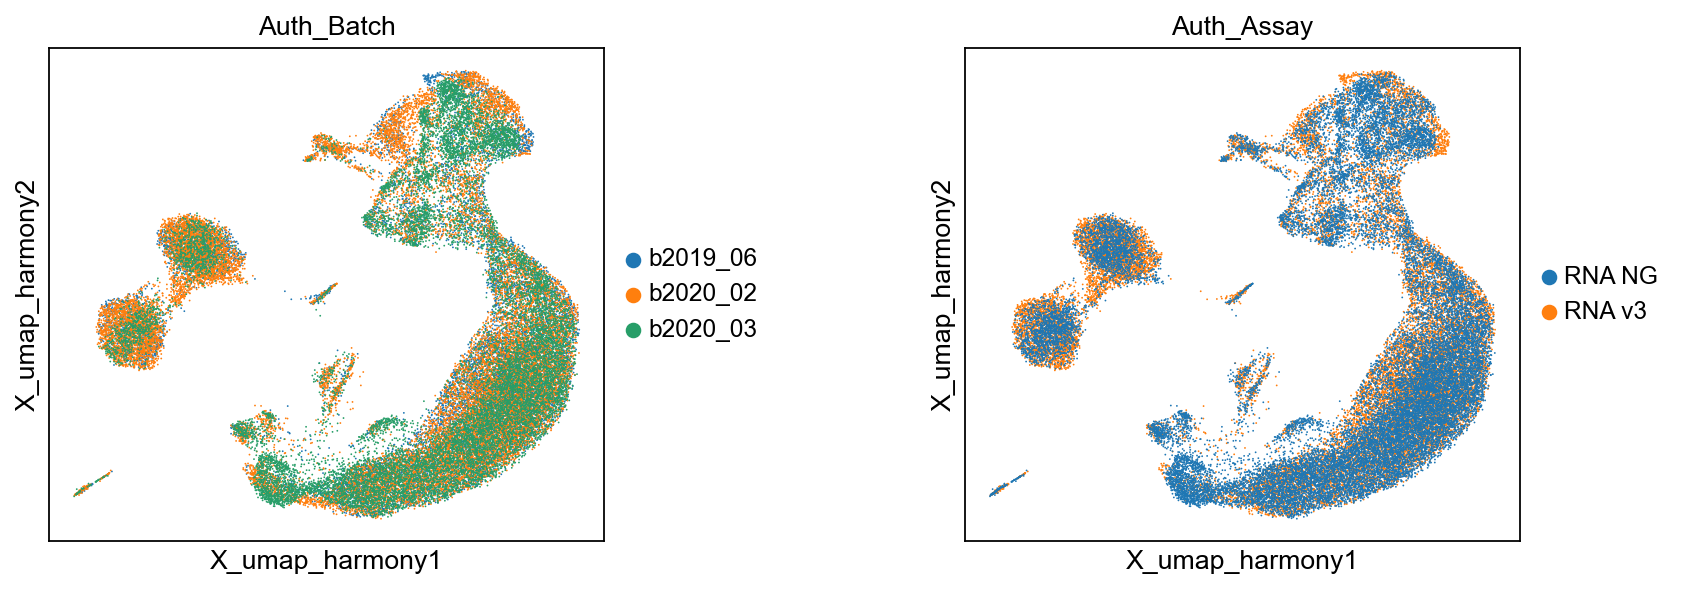

In [47]:
if 'cell_label' in adata.obs.columns:
    sc.pl.embedding(adata, basis="X_umap_harmony", color=['Auth_Batch', 'Auth_Assay'], wspace=0.5)

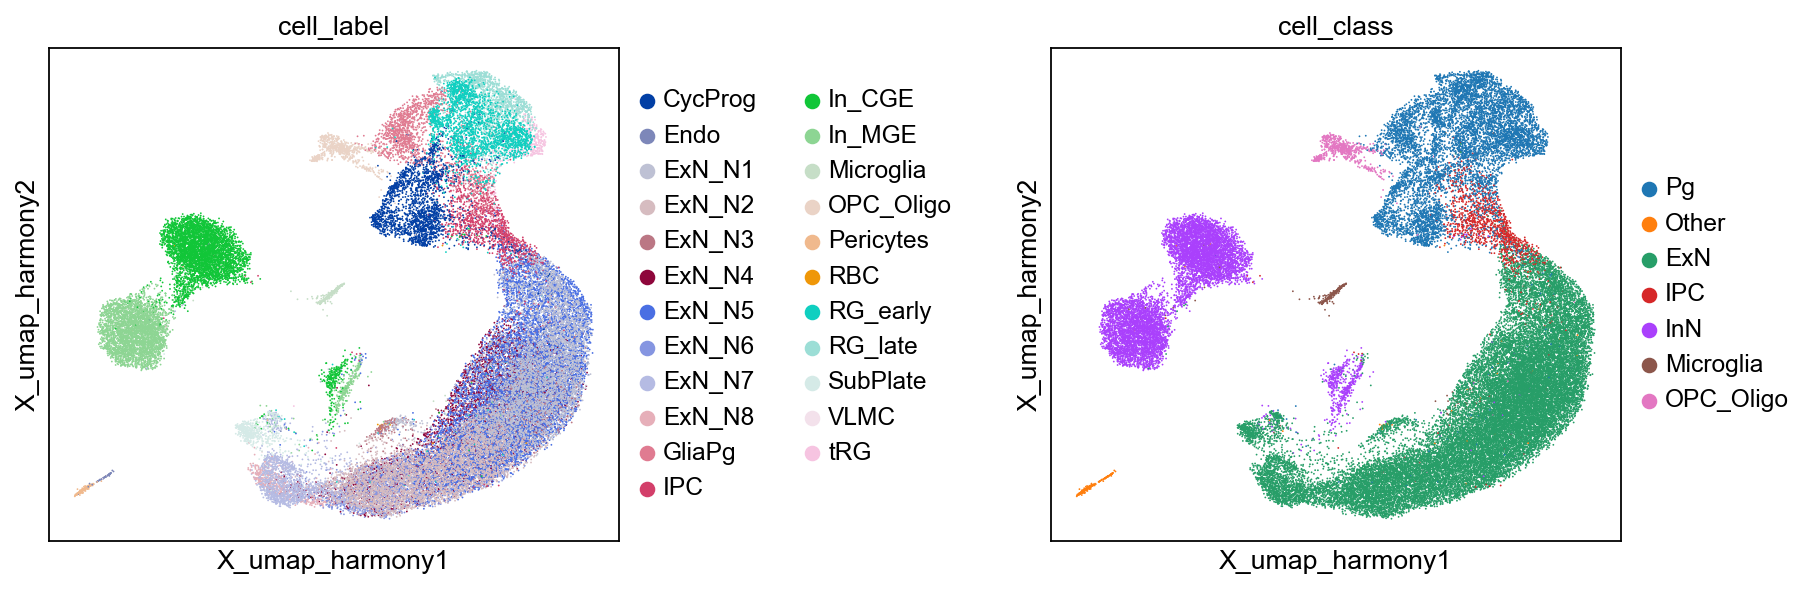

In [48]:
if 'cell_label' in adata.obs.columns:
    sc.pl.embedding(adata, basis="X_umap_harmony", color=['cell_label', 'cell_class'], wspace=0.6)

## 8.2 Diffution Map

In [49]:
sc.tl.diffmap(adata, random_state=1, neighbors_key="harmony")
adata.obsm["X_diffmap_harmony"] = adata.obsm["X_diffmap"].copy()
del adata.obsm["X_diffmap"]

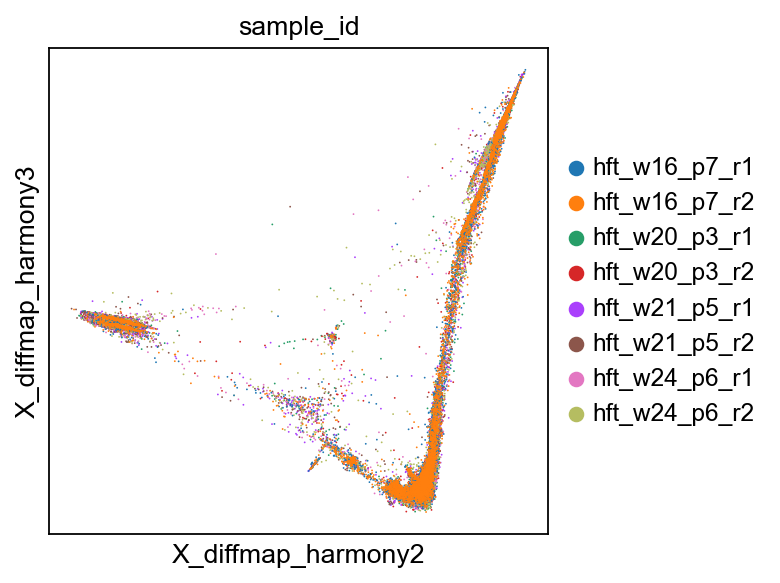

In [50]:
sc.pl.embedding(
    adata,
    basis="X_diffmap_harmony",
    components=['2,3'],
    color=['sample_id']
    )

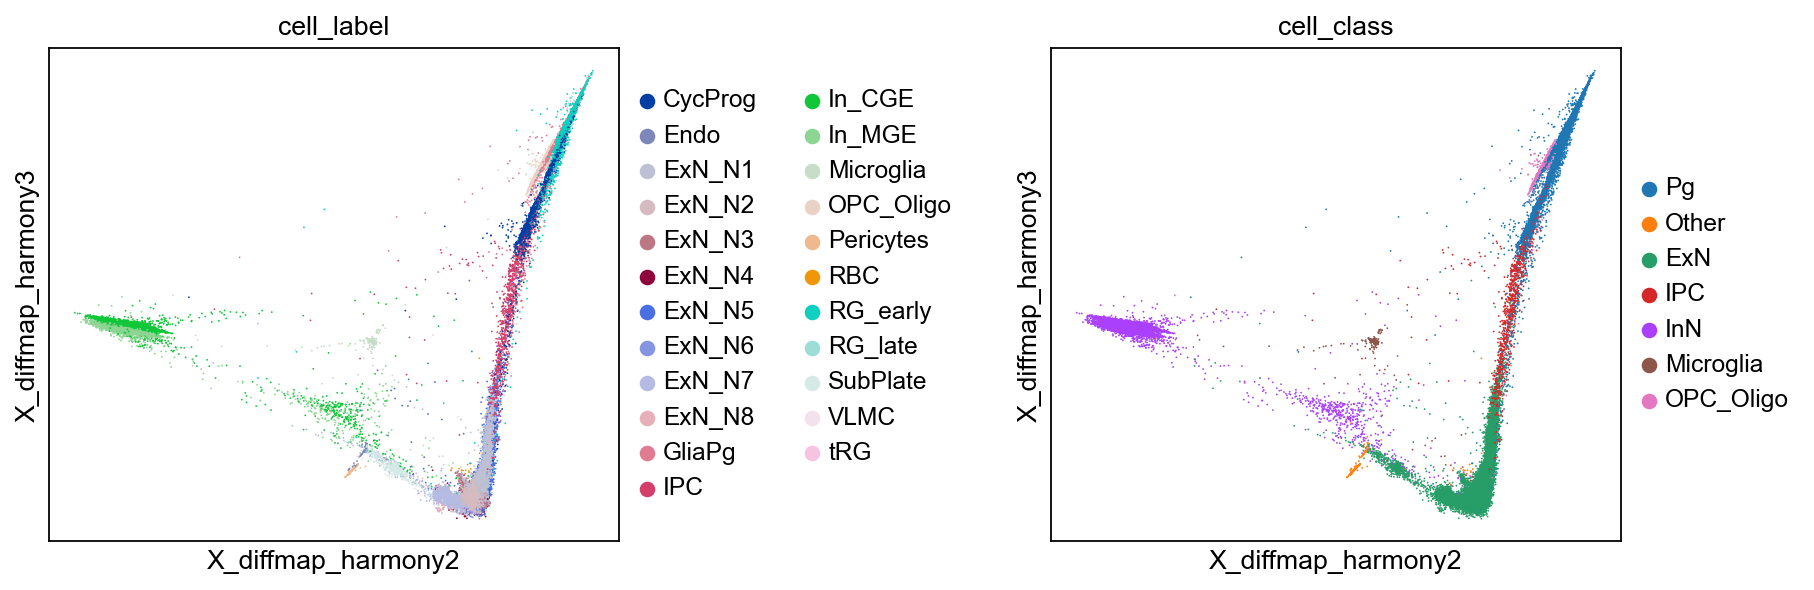

In [51]:
if 'cell_label' in adata.obs.columns:
    sc.pl.embedding(
        adata,
        basis="X_diffmap_harmony",
        components=['2,3'],
        color=['cell_label', 'cell_class'],
        wspace=0.6
        )

## 9. Clusters

## 9.1 Cluster Identification

In [52]:
leiden_res = [0.2, 0.4, 0.6, 1.0]
leiden_labels = []

for x in leiden_res:
    label = "Leiden_" + str(x).replace('.', '')
    leiden_labels.append(label) 
    # updated with future scanpy deafult
    sc.tl.leiden(adata, resolution=x, key_added=label, neighbors_key="harmony", 
                 flavor='igraph', n_iterations=2, directed=False, random_state=0)

## 9.2 Clusters on UMAP

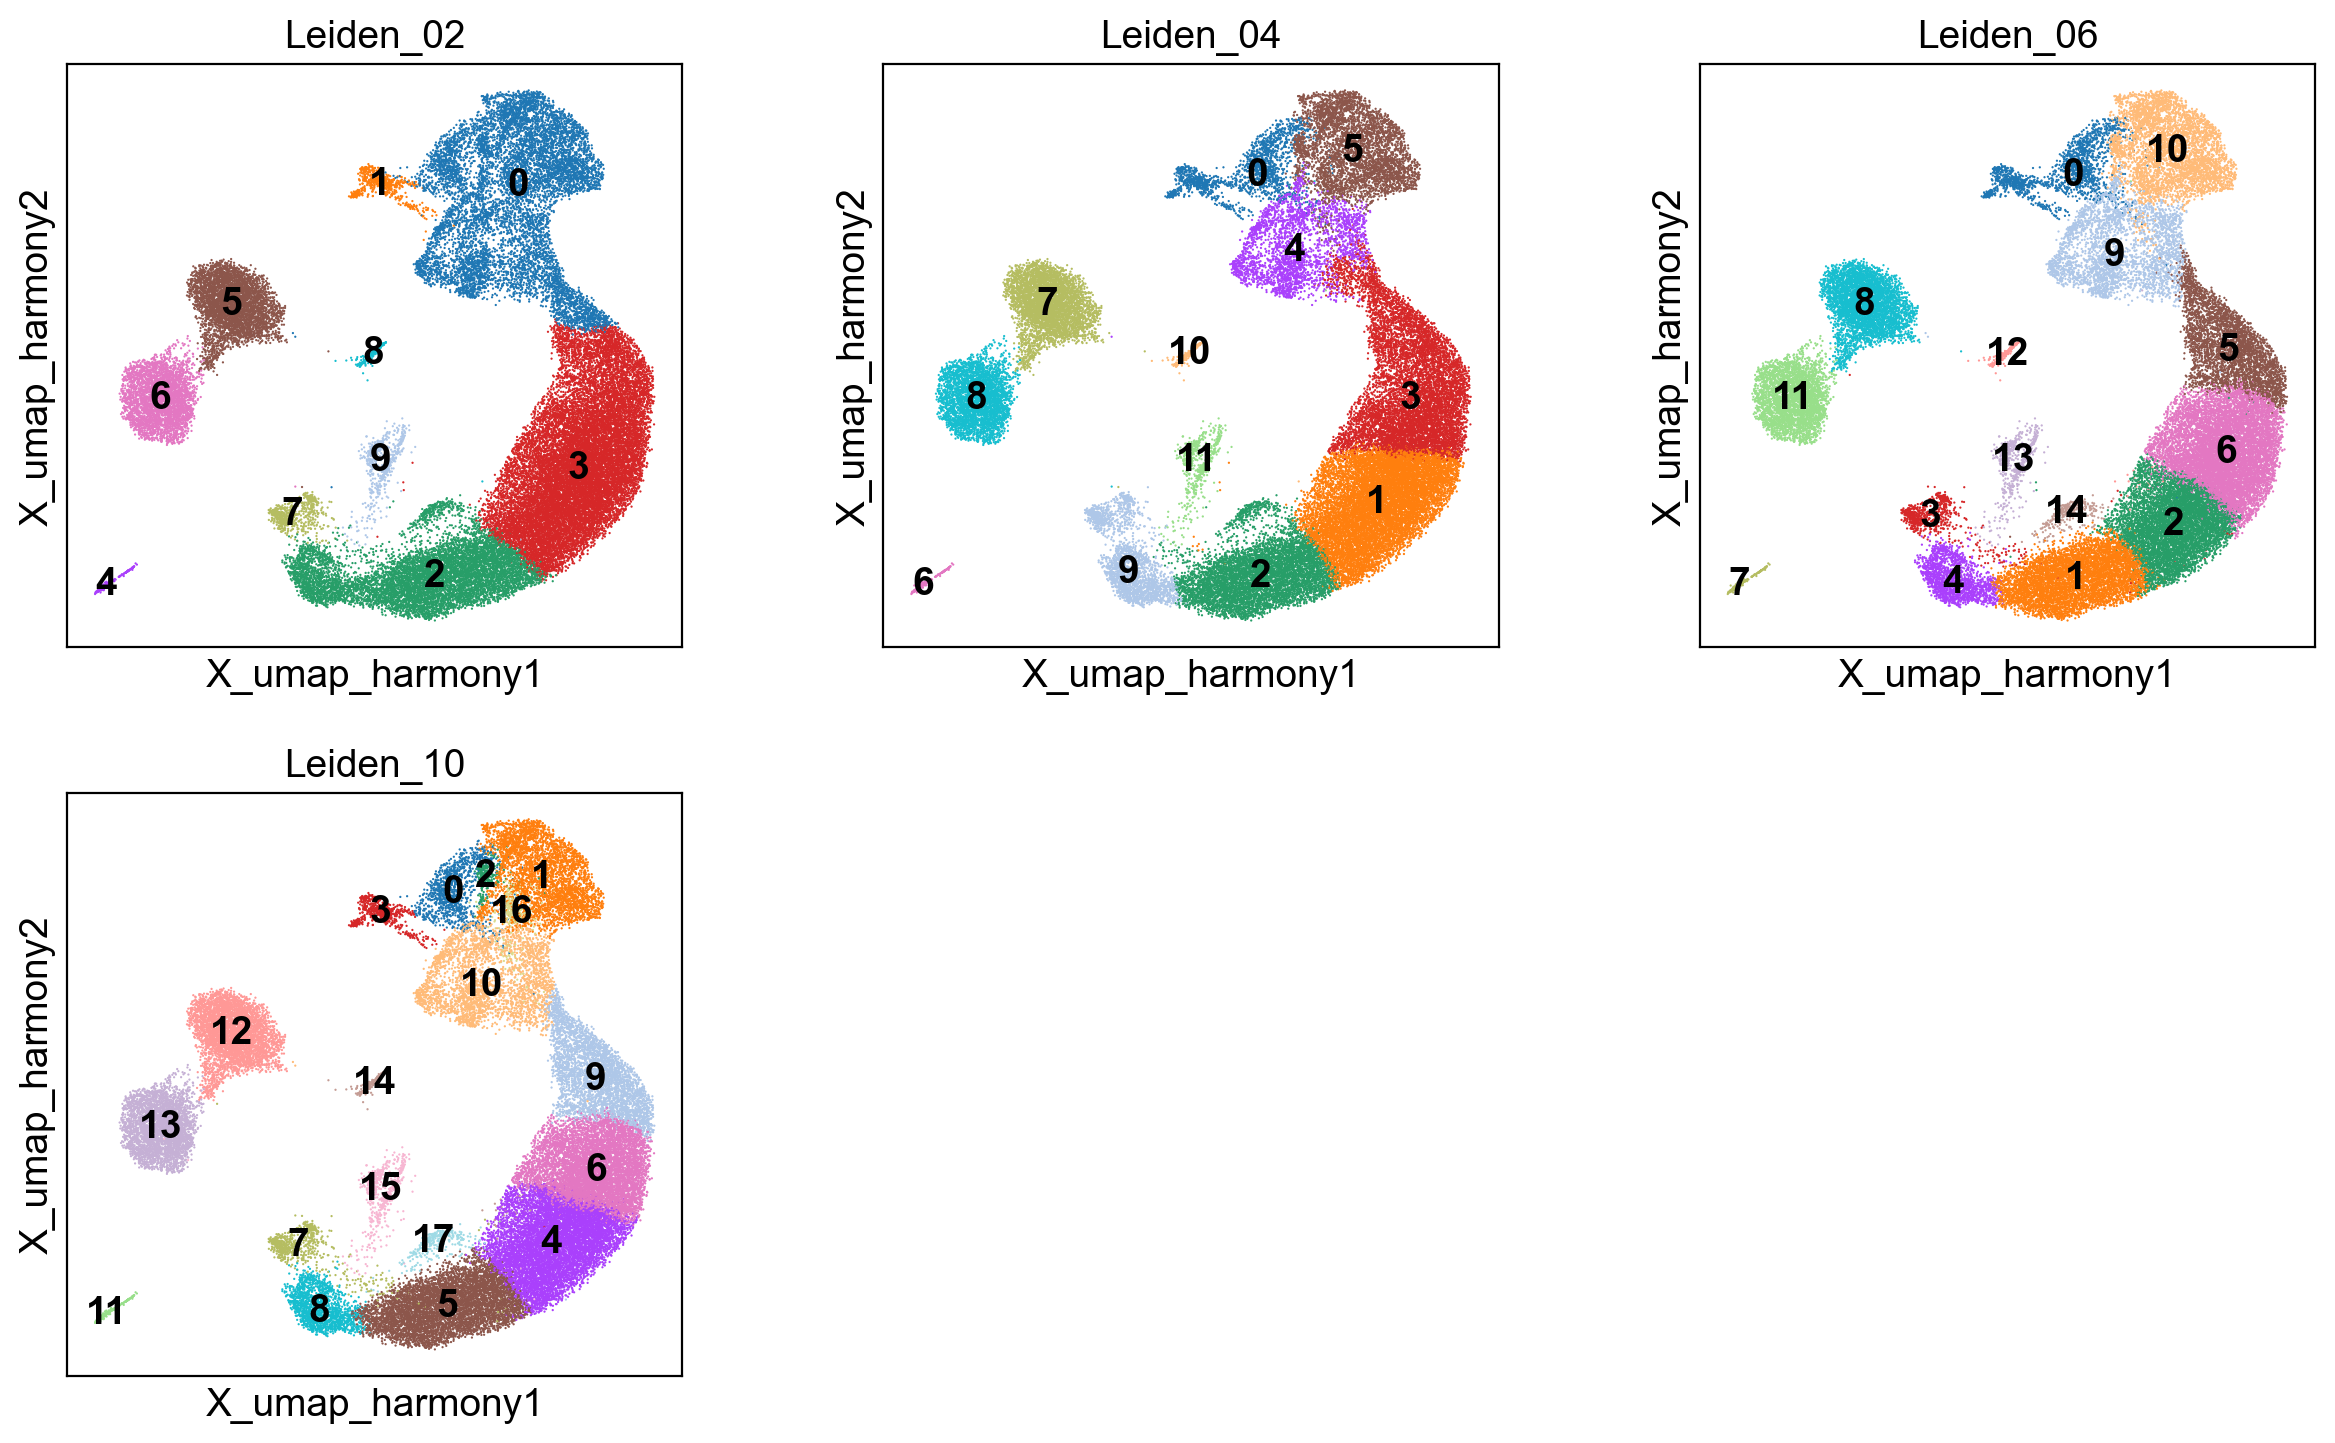

In [53]:
sc.settings.set_figure_params(dpi=100)
sc.pl.embedding(adata, basis="X_umap_harmony", color=leiden_labels, 
               ncols=3, legend_loc='on data')

## 9.3 Choose resolution

In [54]:
adata.obs['Leiden_Sel'] = adata.obs[chosen_leiden]

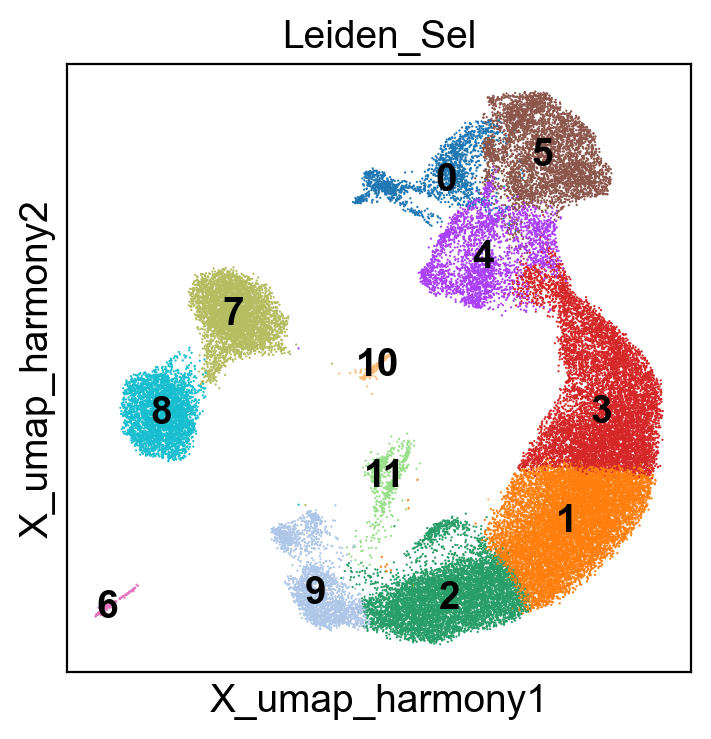

In [55]:
sc.pl.embedding(adata, basis="X_umap_harmony", color='Leiden_Sel',
                legend_loc='on data')

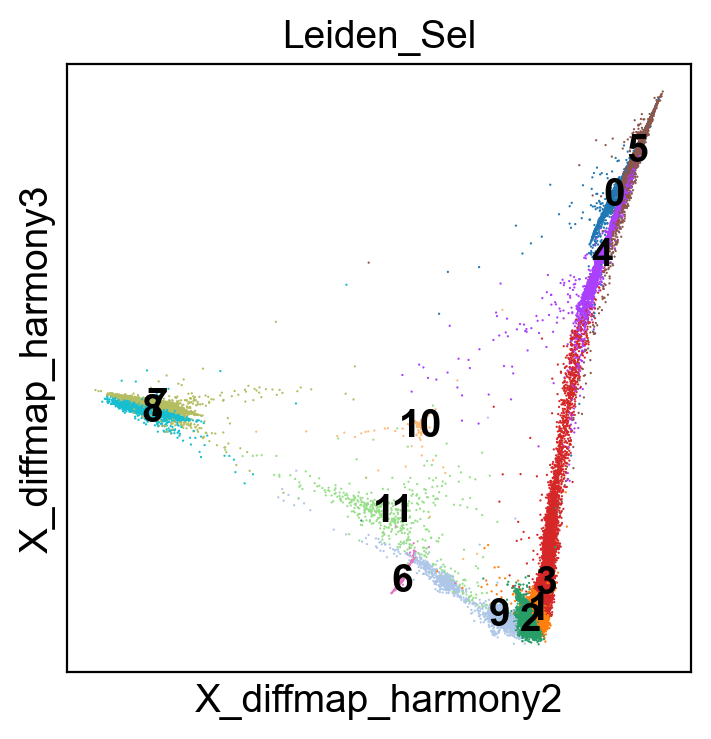

In [56]:
sc.pl.embedding(adata, basis="X_diffmap_harmony", components=['2,3'], 
                color='Leiden_Sel', legend_loc='on data')

## 10. Saving
## 10.1 Save Adata

In [57]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [58]:
output_file = f'../data/{id}/Day1_2_TrevinoFiltNormAdata.h5ad'
adata.write(output_file)